In [2]:
import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib as mpl
import gmplot
import os

import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

In [324]:
min_s=1.
max_s=1.3
norm = mpl.colors.Normalize(vmin=min_s, vmax=max_s)
m = cm.ScalarMappable(norm=norm, cmap='coolwarm')

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def get_hex(scalar):
    return(rgb_to_hex(m.to_rgba(scalar,bytes=True)[:3]))

print get_hex(1.2)

#f6b79c


In [10]:
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = plt.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels!=None:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = plt.get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in xrange(N + 1)]
    return mpl.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

##Manhattan Basemap Plotting

Much of the code below was repurposed from [here](http://sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.V0RrFfkrLIU). They really did a great job of documenting their code, explaining some idiosynchrasies of the Basemap package, and ultimately ended up with a really stellar rendering of London.

In [17]:
records['surge'].max()

1.0

#6485eb


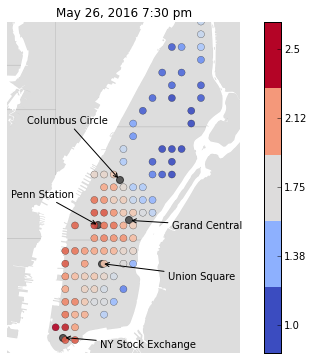

In [18]:
records=pd.DataFrame()

for i in os.listdir(os.getcwd()+'\\output\\pm_rush\\may_25\\late_rush'):
    file_name='output\\pm_rush\\may_25\\late_rush\\'+ i
    #pd.records=pd.concat([records,pd.read_csv(file_name)])
    records=pd.concat([pd.read_csv(file_name),records])
    
#print(len(records))
#records.head()

##############

f='pm_rush_hour_05_26_2016_19_38_09'
time='7:30 pm'
date='May 26, 2016'
#records=pd.read_csv('output\\pm_rush\\may_25\\late_rush\\'+f+'.csv')
records=records.groupby('ref_num').agg({'lat_round':np.mean,'lng_round':np.mean,'surge':np.mean}).reset_index()

###############

min_s=1.
max_s=2.5
norm = mpl.colors.Normalize(vmin=min_s, vmax=max_s)
m = cm.ScalarMappable(norm=norm, cmap='coolwarm')

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def get_hex(scalar):
    return(rgb_to_hex(m.to_rgba(scalar,bytes=True)[:3]))

print get_hex(1.2)

##############
from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
#from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain

shp = fiona.open('nyc_land/new-york_new-york_land_coast.shp')
#shp = fiona.open('london/london_wards.shp')

bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

###################
m = Basemap(
    projection='merc',
    ellps = 'WGS84',
    llcrnrlat=40.7,urcrnrlat=40.83,\
    llcrnrlon=-74.04, urcrnrlon=-73.92,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    'nyc_land/new-york_new-york_land_coast',
    'nyc',
    color='none',
    zorder=2)

df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.nyc],
    'FID': [ward['FID'] for ward in m.nyc_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(records['lng_round'],records['lat_round'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
ldn_points = filter(wards_polygon.contains, plaque_points)

# Highlight points in order: Grand Central, Penn Station, Union Square, Columbus Circle, NY Stock Exchange
highlight1_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip([-73.977,-73.993,-73.991, -73.982,-74.011],[40.752,40.75,40.735,40.768,40.706])])
highlight2_points = MultiPoint(list(highlight1_points.values))
highlight_points = filter(wards_polygon.contains, highlight2_points)
annotate1_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip([-73.955 ,-74.038,-73.957, -74.03,-73.992],[40.749,40.761,40.729,40.790,40.702])])
annotate2_points = MultiPoint(list(annotate1_points.values))
annotate_points = filter(wards_polygon.contains, annotate2_points)

#######################

df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#555555',
    ec='#787878', lw=.25, alpha=.2,
    zorder=4))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in ldn_points],
    [geom.y for geom in ldn_points],
    50, marker='o', lw=.25,
    #facecolor='#33ccff', edgecolor='w',
    c=np.log(records['surge'].values), cmap='coolwarm',
    alpha=0.9, antialiased=True,
    label='NYC Test', zorder=3)
dev_highlights = m.scatter(
    [geom.x for geom in highlight_points],
    [geom.y for geom in highlight_points],
    50, marker='o', lw=1,
    #facecolor='#33ccff', edgecolor='w',
    facecolors='black', edgecolors='black',
    alpha=.6, antialiased=True,
    label='NYC Test', zorder=2)

annotate_text=['Grand Central', 'Penn Station', 'Union Square', 'Columbus Circle', 'NY Stock Exchange']

for i in np.arange(0,len(annotate_text)):
    
    ax.annotate(annotate_text[i], xy=(highlight_points[i].x, highlight_points[i].y), xytext=(annotate_points[i].x, annotate_points[i].y),
                arrowprops=dict(facecolor='black', arrowstyle="->"),
                )
# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
colorbar_index(5, 'coolwarm', labels=np.linspace(min_s,max_s,5).round(2))

#ax.annotate('axes center', xy=(2, .5), xycoords='axes fraction')

plt.title(date+" "+time)
#plt.title('May 25, 4 pm - 7:30 pm Avg Surge')
#plt.title('May 25, 7:30 - 10 pm Avg Surge')
plt.tight_layout()
# this will set the image width to 722px at 100dpi
fig.set_size_inches(7.22, 5.25)
#plt.savefig("images\\pm_rush\\may_26\\"+f+'.png', dpi=100, alpha=True)
#plt.savefig("images\\pm_rush\\may_25\\avg\\may_25_pm_rush_avg.png", dpi=100, alpha=True)

plt.show()


##Brooklyn Basemap Plotting


#f6b79c


IOError: [Errno 2] No such file or directory: 'brooklyn\\images\\brunch_sat\\brunch_sat_5_29.png'

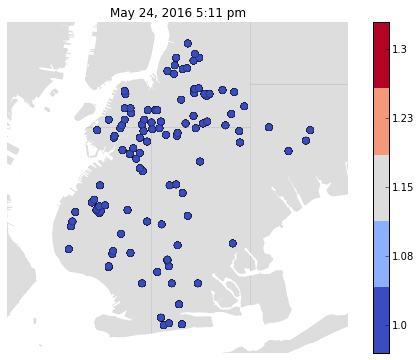

In [11]:
records=pd.DataFrame()

for i in os.listdir(os.getcwd()+'\\brooklyn\\brunch_sat'):
    file_name='brooklyn\\brunch_sat\\'+ i
    #pd.records=pd.concat([records,pd.read_csv(file_name)])
    records=pd.concat([pd.read_csv(file_name),records])
    
#print(len(records))
#records.head()

##############

f='pm_rush_hour_05_24_2016_17_11_39'
time='5:11 pm'
date='May 24, 2016'
#records=pd.read_csv('brooklyn\\pm_rush\\'+f+'.csv')
avg_surge=records.groupby('ref_num').agg({'lat_round':np.mean,'lng_round':np.mean,'surge':np.mean}).reset_index()

###############

min_s=1.
max_s=1.3
norm = mpl.colors.Normalize(vmin=min_s, vmax=max_s)
m = cm.ScalarMappable(norm=norm, cmap='coolwarm')

def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def get_hex(scalar):
    return(rgb_to_hex(m.to_rgba(scalar,bytes=True)[:3]))

print get_hex(1.2)

########################

## SHAPEFILE TEST

from lxml import etree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
#from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import fiona
from itertools import chain

shp = fiona.open('nyc_land/new-york_new-york_land_coast.shp')
#shp = fiona.open('london/london_wards.shp')

bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

m = Basemap(
    projection='merc',
    ellps = 'WGS84',
    llcrnrlat=40.562,urcrnrlat=40.736,\
    llcrnrlon=-74.073, urcrnrlon=-73.838,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    'nyc_land/new-york_new-york_land_coast',
    'nyc',
    color='none',
    zorder=2)

df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.nyc],
    'FID': [ward['FID'] for ward in m.nyc_info]})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(records['lng_round'],records['lat_round'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, plaque_points)

##########################

df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x,
    fc='#555555',
    ec='#787878', lw=.25, alpha=.2,
    zorder=4))

plt.clf()
fig = plt.figure()
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

# we don't need to pass points to m() because we calculated using map_points and shapefile polygons
dev = m.scatter(
    [geom.x for geom in ldn_points],
    [geom.y for geom in ldn_points],
    50, marker='o', lw=.25,
    #facecolor='#33ccff', edgecolor='w',
    c=np.log(records['surge'].values), cmap='coolwarm',
    alpha=0.9, antialiased=True,
    label='NYC Test', zorder=3)
# plot boroughs by adding the PatchCollection to the axes instance
ax.add_collection(PatchCollection(df_map['patches'].values, match_original=True))
colorbar_index(5, 'coolwarm', labels=np.linspace(min_s,max_s,5).round(2))

plt.title(date+" "+time)
plt.tight_layout()
# this will set the image width to 722px at 100dpi
fig.set_size_inches(7.22, 5.25)
plt.savefig("brooklyn\\images\\brunch_sat\\brunch_sat_5_29.png", dpi=100, alpha=True)
plt.show()